In [1]:
import os
import pandas as pd
import nltk
import requests
import string
from gensim.models import Word2Vec, KeyedVectors
import shutil
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import shap


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_use]

In [4]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    5909 non-null   int64 
 1   Unnamed: 0      5909 non-null   int64 
 2   helpful_votes   5909 non-null   int64 
 3   location_id     5909 non-null   int64 
 4   lang            5909 non-null   object
 5   review_id       5909 non-null   int64 
 6   review          5909 non-null   object
 7   review_subject  5909 non-null   object
 8   trip_type       5892 non-null   object
 9   travel_date     5892 non-null   object
 10  rating          5909 non-null   int64 
 11  location_name   5909 non-null   object
 12  province        5909 non-null   object
 13  place_id        5909 non-null   object
 14  cleaned_review  5909 non-null   object
 15  emotion         5909 non-null   object
dtypes: int64(6), object(10)
memory usage: 738.8+ KB


In [5]:
review_df.describe()

,helpful_votes,location_id,review_id,rating
count,5909.000000,5.909000e+03,5.909000e+03,5909.000000
mean,1.058216,6.483167e+06,7.590446e+08,4.153833
std,5.625108,4.877561e+06,1.844114e+08,1.067077
min,0.000000,3.110380e+05,1.049076e+08,1.000000
25%,0.000000,2.578107e+06,6.573250e+08,4.000000
50%,0.000000,6.017599e+06,7.832754e+08,4.000000
75%,1.000000,8.818088e+06,9.240324e+08,5.000000
max,182.000000,2.714283e+07,9.653184e+08,5.000000


In [6]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   helpful_votes   5909 non-null   int64 
 1   location_id     5909 non-null   int64 
 2   review_id       5909 non-null   int64 
 3   review          5909 non-null   object
 4   review_subject  5909 non-null   object
 5   trip_type       5892 non-null   object
 6   rating          5909 non-null   int64 
 7   location_name   5909 non-null   object
 8   province        5909 non-null   object
 9   place_id        5909 non-null   object
 10  emotion         5909 non-null   object
 11  cleaned_review  5909 non-null   object
dtypes: int64(4), object(8)
memory usage: 554.1+ KB


In [7]:
review_df

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review
0,0,2209612,953596359,Besides elegant grand palace and wat pra kaew ...,"The place is nearby grand palace, in the area ...",Family,5,Wat Ratchabophit,Bangkok,P03013220,joy,besides elegant grand palace <OOV> wat pra kae...
1,0,2209612,938998692,This is one of the last big king temples of Ba...,Nice Wat,Solo travel,4,Wat Ratchabophit,Bangkok,P03013220,joy,<OOV> <OOV> one <OOV> <OOV> last big king temp...
2,6,2209612,933065689,"It is beautiful, clean and free to enter. Both...",Nice views,Solo travel,4,Wat Ratchabophit,Bangkok,P03013220,joy,<OOV> <OOV> beautiful clean <OOV> free <OOV> e...
3,0,2209612,885904967,Wat Ratchabophit is a Buddhist temple located ...,Wat Ratchabophit - a temple characterized by u...,Couples,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> buddhist temple l...
4,4,2209612,782967555,Wat Ratchabophit is a historic royal temple bu...,"Beautiful, peaceful",NONE,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> historic royal te...
...,...,...,...,...,...,...,...,...,...,...,...,...
5904,0,1831068,888281929,Is quite far from Korat Town or main highway. ...,Can visit.. depends on individual,Family,3,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> quite far <OOV> korat town <OOV> main hi...
5905,4,1831068,752115552,Prasat Pueai Noi is claimed to be the biggest ...,"Small, Isolated Khmer Sanctuary",NONE,3,Prasat Puay Noi,Nonthaburi,P03013503,joy,prasat pueai noi <OOV> claimed <OOV> <OOV> <OO...
5906,0,1831068,693354319,I think this place is claimed to be the oldest...,A sense of ancient times..,Friends getaway,4,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> think <OOV> place <OOV> claimed <OOV> <O...
5907,1,1831068,573376614,The compound comprises three brick buildings o...,Another Angkor Wat,Solo travel,4,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> compound comprises three brick buildings...


In [8]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = "Hello Mr. Smith, how are you doing today? The weather is great and Python is awesome. The sky is pinkish-blue. You should not eat cardboard."
word_tokenize ( text )
sent_tokenize ( text )

['Hello Mr. Smith, how are you doing today?',
 'The weather is great and Python is awesome.',
 'The sky is pinkish-blue.',
 'You should not eat cardboard.']

In [9]:
from nltk.corpus import stopwords 

custom_stopwords = set(stopwords.words('english'))

In [10]:
from nltk.stem import WordNetLemmatizer

stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [11]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if word not in string.punctuation]
    return ' '.join(words)

In [12]:
# Apply preprocessing to the review texts
review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)

# 2. สร้าง Word Embeddings ด้วย Word2Vec
# word2vec_model = Word2Vec(sentences=review_df['cleaned_review'], vector_size=300, window=5, min_count=1, sg=1)  # ใช้ Skip-Gram
sentences = [row.split() for row in review_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_9383/2616607316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)


In [13]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_len = 100  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [14]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_9383/1367629667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


In [15]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating in [3, 4]:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_9383/2638035927.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)


In [16]:
from sklearn.utils import resample

# Assuming `review_df` is your original DataFrame with a 'sentiment' column

# 1. Separate the data by class
df_positive = review_df[review_df.sentiment == 'positive']
df_neutral = review_df[review_df.sentiment == 'neutral']
df_negative = review_df[review_df.sentiment == 'negative']

# 2. Resample the minority classes
# For example, oversample the neutral and negative classes to match the positive class
df_neutral_upsampled = resample(df_neutral,
                                replace=True,  # Sample with replacement
                                n_samples=len(df_positive),  # Match number of positive class samples
                                random_state=42)  # Reproducible results

df_negative_upsampled = resample(df_negative,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_positive),  # Match number of positive class samples
                                 random_state=42)  # Reproducible results

# 3. Combine the resampled DataFrames
df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# 4. Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 5. Check the distribution of the classes
print(df_balanced['sentiment'].value_counts())


sentiment
neutral     2871
positive    2871
negative    2871
Name: count, dtype: int64


In [17]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_len)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [19]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (6890, 100)
y_train shape: (6890,)
X_test shape: (1723, 100)
y_test shape: (1723,)


In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Step 6: Build the LSTM Model
dropout_rate = 0.5
input_shape = X_train_resampled.shape[1:] 

# สร้างโมเดลด้วย L2 Regularization และ Dropout
# CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
model_cnn.add(Conv1D(128, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [23]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [24]:
class_weights_dict = dict(enumerate(class_weights))

In [37]:
class_weights_dict

{0: 1.0064271107215892, 1: 0.9869646182495344, 2: 1.0068683326026597}

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/BiLSTM_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล

history = model_cnn.fit(X_train_resampled, 
                 y_train_resampled, 
                 epochs=20, 
                 batch_size=64, 
                 callbacks=[early_stopping, model_checkpoint],
                 validation_data=(X_val, y_val),
                 class_weight=None)



Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3405 - loss: 0.1459 - val_accuracy: 0.3366 - val_loss: -2.5114
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3951 - loss: -10.9127 - val_accuracy: 0.4132 - val_loss: -81.0655
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4252 - loss: -140.5746 - val_accuracy: 0.3720 - val_loss: -451.3820
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4207 - loss: -615.3425 - val_accuracy: 0.3697 - val_loss: -1332.2675
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4225 - loss: -1673.4418 - val_accuracy: 0.3807 - val_loss: -2907.7068
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4290 - loss: -3454.7100 - val_accuracy: 0.3720 - val_loss: -5218.2646
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4136 - loss: -5926.2305 - val_accuracy: 0.3778 - val_loss: -8534.6123
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - 

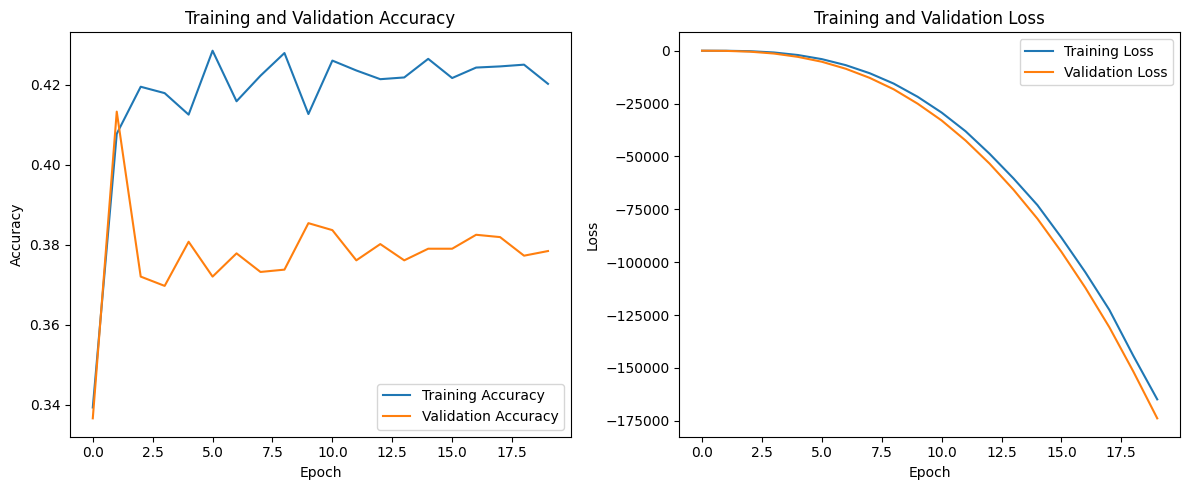

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import load_model

# โหลดโมเดล LSTM ที่ดีที่สุด
best_model = load_model('../../models/CNN_models_sample.keras')

In [29]:
# ใช้โมเดล LSTM ทำนายข้อมูล validation set
lstm_preds = best_model.predict(X_val)
lstm_preds = np.argmax(lstm_preds, axis=1)

# ฝึก Gradient Boosting Classifier บนผลลัพธ์จาก LSTM
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(lstm_preds.reshape(-1, 1), y_val)

# ทำนายผลลัพธ์ด้วย Gradient Boosting
ensemble_preds = gb_clf.predict(lstm_preds.reshape(-1, 1))

# ตรวจสอบผลลัพธ์
print(classification_report(y_val, ensemble_preds))
print(confusion_matrix(y_val, ensemble_preds))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       589
           1       0.00      0.00      0.00       544
           2       0.34      1.00      0.51       590

    accuracy                           0.34      1723
   macro avg       0.11      0.33      0.17      1723
weighted avg       0.12      0.34      0.17      1723

[[  0   0 589]
 [  0   0 544]
 [  0   0 590]]


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [30]:
lstm_preds = best_model.predict(X_val)
lstm_preds = np.argmax(lstm_preds, axis=1)

print(classification_report(y_val, lstm_preds))
print(confusion_matrix(y_val, lstm_preds))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51       589
           1       0.00      0.00      0.00       544
           2       0.00      0.00      0.00       590

    accuracy                           0.34      1723
   macro avg       0.11      0.33      0.17      1723
weighted avg       0.12      0.34      0.17      1723

[[589   0   0]
 [544   0   0]
 [590   0   0]]


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [31]:
# สร้างโมเดล Random Forest (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf_model.predict(X_val)

# สร้างโมเดล Gradient Boosting (Boosting)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model.predict(X_val)

# วัดผลลัพธ์ของแต่ละโมเดล
print("Random Forest Accuracy:", accuracy_score(y_val, rf_predictions))
print("Gradient Boosting Accuracy:", accuracy_score(y_val, gb_predictions))

Random Forest Accuracy: 0.8276262333139872
Gradient Boosting Accuracy: 0.6604759141033082


In [97]:
# Ensemble วิธี Voting (Hard Voting)
from sklearn.ensemble import VotingClassifier

# รวมโมเดลทั้งสองด้วยการ Voting
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model), ('gb', gb_model)],
    voting='hard')

voting_model.fit(X_train_resampled, y_train_resampled)
voting_predictions = voting_model.predict(X_val)

# วัดผลลัพธ์จากการใช้ Voting
print("Voting Ensemble Accuracy:", accuracy_score(y_val, voting_predictions))

Voting Ensemble Accuracy: 0.6993615786419036


In [98]:
y_val

4205    2
1665    1
3121    2
3126    2
3688    0
       ..
8510    1
7445    2
2132    0
247     1
4011    2
Name: sentiment, Length: 1723, dtype: int64

In [112]:
common_indices = y_val.index.intersection(review_df.index)
missing_indices = y_val.index.difference(review_df.index)
print(f"Common indices count: {len(common_indices)}")
print(f"Missing indices count: {len(missing_indices)}")

Common indices count: 1170
Missing indices count: 553


In [110]:
# y_val = y_val.iloc[:-1]

In [107]:
predict_label = y_val

In [113]:
redicted_df = pd.DataFrame({'predicted': ensemble_preds}, index=y_val.index)
    
    # Concatenate y_val and the new predicted_df to create a new DataFrame
predict_df = pd.concat([y_val, redicted_df], axis=1)

In [115]:
predict_df

,sentiment,predicted
4205,2,1
1665,1,1
3121,2,2
3126,2,1
3688,0,0
...,...,...
8510,1,1
7445,2,2
2132,0,0
247,1,1


In [116]:
valid_y_val = predict_df.loc[predict_df.index.isin(review_df.index)]

# Now you can safely use .loc with valid_y_val indices
filtered_reviews = review_df.loc[valid_y_val.index]

In [117]:
filtered_reviews

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review,embedding,sentiment
4205,0,11867768,660193827,"The place is a real gem, nestling in the cool ...",Not to be Missed!,Couples,5,The Royal Agricultural Station Angkhang,Phetchabun,P03012884,joy,place real gem nestling cool green upland doi ...,"[[-0.0031354371458292007, 0.08185625076293945,...",positive
1665,0,16868178,893223254,"Nice view, but you need to be be careful when ...",Nice view,Friends getaway,5,Chado Cliff Viewpoint,Phra Nakhon Si Ayutthaya,P03017905,joy,nice view need careful hiking natural trail be...,"[[-0.026523858308792114, 0.24474334716796875, ...",positive
3121,1,556614,874997345,Doi Mae Salong is a beautiful and interesting ...,Beautiful and peaceful,NONE,5,Doi Mae Salong,Nakhon Sawan,P03016134,joy,doi mae salong beautiful interesting place vis...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
3126,0,6669517,632751727,Located on the way we back to our accommodatio...,temple that next to the road,Couples,3,Chedi Phra Borommasaririkkathat Khao Kho,Nakhon Sawan,P03016132,joy,located way back accommodation look time avail...,"[[-0.010012944228947163, 0.07716846466064453, ...",neutral
3688,1,7659431,613000573,i stayed on koh larn at the castello resort ov...,i love this island so much,Solo travel,5,Thong Lang Beach,Sukhothai,P03025214,joy,stayed koh larn castello resort christmas enjo...,"[[5.367626727093011e-05, 0.012896074913442135,...",positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0,8874054,875897422,Chaio por Phawo Shrine is the most popular pra...,Most Respect shine in Mae sot People,NONE,5,Chao Por Phawo Shrine,Nonthaburi,P03016494,joy,chaio por phawo shrine popular pray respect pl...,"[[-0.013652702793478966, 0.11288685351610184, ...",positive
4129,1,1307603,750690836,Took a fast boat for a magical day at Hapla Be...,Blissful,Couples,5,Koh Kho Khao Island,Phetchabun,P03004050,joy,took fast boat magical day hapla beach real ro...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
2132,0,554864,696305303,in the twelfe-year animal cycle the rabbit is ...,the rabbit temple,Couples,5,Wat Phrathat Chae Haeng,Sing Buri,P03013402,joy,twelfeyear animal cycle rabbit one wat phra ch...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
247,0,25571501,929540899,We went on a weekday and was pleased that this...,Best Jodd Fair,Friends getaway,5,Jodd Fairs DanNeramit,Bangkok,P03022261,joy,went weekday pleased jodd fair wasnt packed ma...,"[[-0.0012631779536604881, 0.031852032989263535...",positive


In [150]:

predictions_df = pd.DataFrame({
    'location_id': filtered_reviews['location_id'],
    'location_name': filtered_reviews['location_name'],
    'trip_type': filtered_reviews['trip_type'],
    'rating': filtered_reviews['rating'],
    'helpful_voting': filtered_reviews['helpful_votes'],
    'review_text': filtered_reviews['review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': predict_df['sentiment'],  # The actual sentiment labels
    'predicted_sentiment': predict_df['predicted']  # The predicted sentiment labels
})

# predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
# predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.head(5)


,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,1
14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",1,1
17,317504.0,Temple Of Dawn (Wat Arun),Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",0,0
19,317504.0,Temple Of Dawn (Wat Arun),Family,4.0,0.0,I have to admit that this is a place i have al...,0,0
23,456322.0,Wat Umong,Family,5.0,0.0,The visit to this temple was a good pick for u...,1,2


In [151]:
predictions_df.to_csv('./output/LSTM_predictions.csv')

In [138]:
y_val = y_val.astype(int)
ensemble_preds_class = ensemble_preds.astype(int)


In [139]:
print(y_val.shape)            # Shape of y_val
print(ensemble_preds.shape) 

(1723,)
(1723,)


In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score directly using ensemble_preds
precision = precision_score(y_val, ensemble_preds, average='weighted')
recall = recall_score(y_val, ensemble_preds, average='weighted')
f1 = f1_score(y_val, ensemble_preds, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Precision: 0.6930
Recall: 0.6883
F1-Score: 0.6807


In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

Macro-Averaged AUC: 0.5000
Micro-Averaged AUC: 0.8566


In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264


In [166]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_class)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.0000
